# Классификация экзопланет

*Экзопланета* (внесолнечная планета) — планета, находящаяся вне Солнечной системы.

## Постановка задачи
Внесолнечные планеты (extrasolar planets) можно разделить по классам:
1. Планета, вращающаяся по орбите вокруг одиночной звезды
2. Планета, вращающаяся по орбите S-типа вокруг двойной звезды
3. Планета, вращающаяся по орбите P-типа вокруг двойной звезды
4. Планета-сирота (межзвездная планета) - объект, являющийся по сути планетой, но не привязанный гравитационно ни к какой звезде.

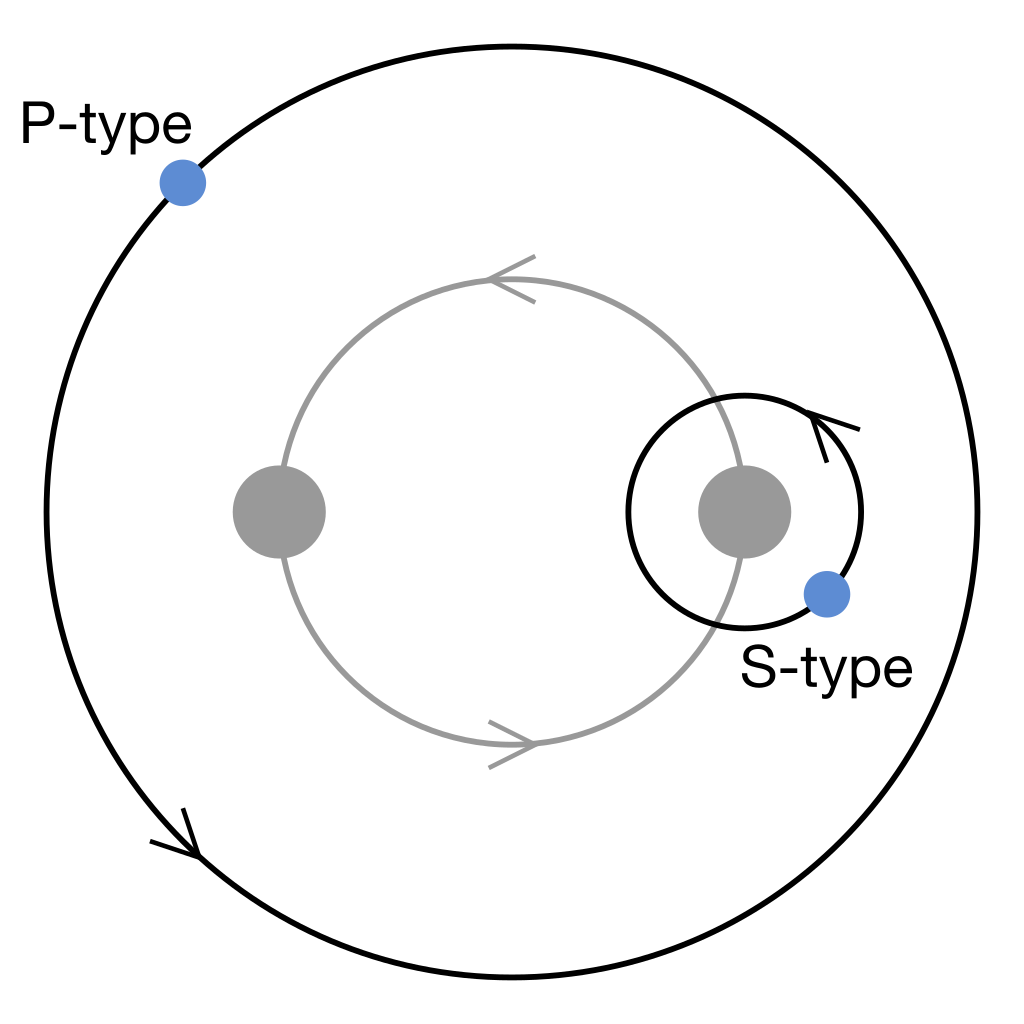

Будем решать задачу в рамках данной выше классификации (по характеристикам небесного тела отнесем его к одному из четырех классов)

## Работа с данными

Возьмем открытый датасет с характеристиками экзопланет.
Ссылка на датасет: https://www.kaggle.com/mrisdal/open-exoplanet-catalogue

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from joblib import Parallel, delayed

Прочитаем данные.

In [2]:
data = pd.read_csv("oec.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PlanetIdentifier      3584 non-null   object 
 1   TypeFlag              3584 non-null   int64  
 2   PlanetaryMassJpt      1313 non-null   float64
 3   RadiusJpt             2774 non-null   float64
 4   PeriodDays            3485 non-null   float64
 5   SemiMajorAxisAU       1406 non-null   float64
 6   Eccentricity          1108 non-null   float64
 7   PeriastronDeg         328 non-null    float64
 8   LongitudeDeg          43 non-null     float64
 9   AscendingNodeDeg      46 non-null     float64
 10  InclinationDeg        665 non-null    float64
 11  SurfaceTempK          741 non-null    float64
 12  AgeGyr                2 non-null      float64
 13  DiscoveryMethod       3521 non-null   object 
 14  DiscoveryYear         3574 non-null   float64
 15  LastUpdated          

Разберемся с признаками.
1. `PlanetIdentifier` - название небесного тела.
2. `TypeFlag` - тип планеты (0=планета, вращающаяся вокруг одной звезды; 1=планета с орбитой P-типа; 2=планета с орбитой S-типа; 3=планета-сирота).
3. `PlanetaryMassJpt` - масса планеты (в массах Юпитера).
4. `RadiusJpt` - радиус планеты (в радиусах Юпитера).
5. `PeriodDays` - период обращения (в днях).


Кеплеровы элементы орбиты (6 элементов):

6. `SemiMajorAxisAU` - большая полуось (в астрономических единицах).
7. `Eccentricity` - эксцентриситет орбиты.
8. `PeriastronDeg` - аргумент перицентра (в градусах).
9. `LongitudeDeg` - долгота (в градусах).
10. `AscendingNodeDeg` - узел орбиты (в градусах).
11. `InclinationDeg` - наклонение (в градусах).


12. `SurfaceTempK` - температура поверхности планеты (в кельвинах).
13. `AgeGyr` - возраст планеты (млрд. лет).
14. `DiscoveryMethod` - метод обнаружения.
15. `DiscoveryYear` - год обнаружения.
16. `LastUpdated` - дата последнего обновления.
17. `RightAscension` - прямое восхождение (в часовой мере) +/-hh mm ss. 
18. `Declination` - склонение (в часовой мере) hh mm ss.
19. `DistFromSunParsec` - расстояние от Солнца (в парсеках).
20. `HostStarMassSlrMass` - масса "хозяйской" звезды (в массах Солнца).
21. `HostStarRadiusSlrRad` - радиус "хозяйской" звезды (в радиусах Солнца).
22. `HostStarMetallicity` - металличность "хозяйской" звезды.
23. `HostStarTempK` - температура "хозяйской" звезды (в кельвинах).
24. `HostStarAgeGyr` - возраст "хозяйской" звезды (млрд. лет).
25. `ListsPlanetIsOn` - список, в который включена планета

### Предобработка данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PlanetIdentifier      3584 non-null   object 
 1   TypeFlag              3584 non-null   int64  
 2   PlanetaryMassJpt      1313 non-null   float64
 3   RadiusJpt             2774 non-null   float64
 4   PeriodDays            3485 non-null   float64
 5   SemiMajorAxisAU       1406 non-null   float64
 6   Eccentricity          1108 non-null   float64
 7   PeriastronDeg         328 non-null    float64
 8   LongitudeDeg          43 non-null     float64
 9   AscendingNodeDeg      46 non-null     float64
 10  InclinationDeg        665 non-null    float64
 11  SurfaceTempK          741 non-null    float64
 12  AgeGyr                2 non-null      float64
 13  DiscoveryMethod       3521 non-null   object 
 14  DiscoveryYear         3574 non-null   float64
 15  LastUpdated          

Удалим столбцы, в которых более половины значений пропущено. Также удалим столбцы `LastUpdated`и `PlanetIdentifier`, т.к. они не несут никакой полезной информации.

In [4]:
data = data.drop(['PlanetaryMassJpt','SemiMajorAxisAU', 'Eccentricity', 'PeriastronDeg', 'LongitudeDeg', 'AscendingNodeDeg', 'InclinationDeg', 'SurfaceTempK', 
                 'AgeGyr', 'HostStarAgeGyr', 'LastUpdated', 'PlanetIdentifier'], axis=1)

Заполним столбцы `RadiusJpt`,`PeriodDays`, `DistFromSunParsec`, `HostStarMetallicity`, `HostStarMassSlrMass`, `HostStarRadiusSlrRad` и `HostStarTempK` медианой.

In [5]:
def fillmedian(names_cols: list):
    for name in names_cols:
        data[name] = data[name].fillna(data[name].median())
fillmedian(['RadiusJpt', 'PeriodDays', 'DistFromSunParsec', 'HostStarMetallicity', 'HostStarMassSlrMass', 'HostStarRadiusSlrRad', 'HostStarTempK'])

In [6]:
data['DiscoveryMethod'].value_counts()

transit         2712
RV               692
imaging           52
microlensing      40
timing            25
Name: DiscoveryMethod, dtype: int64

Чаще всего используется транзитный метод обнаружения. Заполним им пропуски в столбце `DiscoveryMethod`

In [7]:
data['DiscoveryMethod'] = data['DiscoveryMethod'].fillna('transit')

Аналогично поступим с `DiscoveryYear`

In [8]:
data['DiscoveryYear'].value_counts()

2016.0    1415
2014.0     928
2015.0     199
2011.0     189
2013.0     140
2012.0     131
2010.0     120
2009.0      81
2008.0      66
2007.0      64
2005.0      34
2006.0      30
2002.0      30
2004.0      30
2017.0      27
2003.0      25
2000.0      20
2001.0      13
1999.0      11
1996.0       6
1998.0       5
1992.0       4
1995.0       1
1930.0       1
1997.0       1
1846.0       1
1994.0       1
1781.0       1
Name: DiscoveryYear, dtype: int64

In [9]:
data['DiscoveryYear'] = data['DiscoveryYear'].fillna(2016.0)

In [10]:
data['RightAscension']

0             16 01 03
1             16 01 03
2          19 00 03.14
3          19 00 03.14
4          19 00 03.14
             ...      
3579    01 08 35.39148
3580    01 08 35.39148
3581          12 30 26
3582          12 30 26
3583          19 22 33
Name: RightAscension, Length: 3584, dtype: object

In [11]:
data['Declination'] 

0            +33 18 13
1            +33 18 13
2          +40 13 14.7
3          +40 13 14.7
4          +40 13 14.7
             ...      
3579    -10 10 56.1570
3580    -10 10 56.1570
3581         +22 52 47
3582         +22 52 47
3583         +48 59 46
Name: Declination, Length: 3584, dtype: object

Есть два столбца `RightAscension` и `Declination` типа *object* (строка). Они содержат данные, заданные в часовой мере. Переведем их в радианы.

In [12]:
def todegree(s: str):
    if pd.notna(s):
        ans = 0
        k = 1
        l = 3600
        if s[0] == '-':
            k = -1
        for elem in list(map(float, s.split())):
            ans += elem * l
            l //= 60
        return k * math.pi / 43200 * ans
    
    return s

data['RightAscension'] = data['RightAscension'].apply(todegree)
data['Declination'] = data['Declination'].apply(todegree)
    
    
    

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TypeFlag              3584 non-null   int64  
 1   RadiusJpt             3584 non-null   float64
 2   PeriodDays            3584 non-null   float64
 3   DiscoveryMethod       3584 non-null   object 
 4   DiscoveryYear         3584 non-null   float64
 5   RightAscension        3574 non-null   float64
 6   Declination           3574 non-null   float64
 7   DistFromSunParsec     3584 non-null   float64
 8   HostStarMassSlrMass   3584 non-null   float64
 9   HostStarRadiusSlrRad  3584 non-null   float64
 10  HostStarMetallicity   3584 non-null   float64
 11  HostStarTempK         3584 non-null   float64
 12  ListsPlanetIsOn       3584 non-null   object 
dtypes: float64(10), int64(1), object(2)
memory usage: 364.1+ KB


Посмотрим в каких строках остались пропуски.

In [14]:
data[data['RightAscension'].isna()]

,TypeFlag,RadiusJpt,PeriodDays,DiscoveryMethod,DiscoveryYear,RightAscension,Declination,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK,ListsPlanetIsOn
408,0,0.034902,87.9700,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
409,0,0.086565,224.7000,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
410,0,0.091130,365.2422,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
411,0,0.048489,686.9800,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
412,0,1.000000,4332.8200,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
413,0,0.832944,10755.6700,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
414,0,0.362775,30687.1530,transit,1781.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
415,0,0.352219,60190.0300,transit,1846.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
416,0,0.016438,90553.0200,transit,1930.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
995,0,1.200000,3.3000,transit,2011.0,NaN,NaN,333.0,0.977,1.0,2.000000e-02,5700.0,Confirmed planets


In [15]:
data[data['Declination'].isna()]

,TypeFlag,RadiusJpt,PeriodDays,DiscoveryMethod,DiscoveryYear,RightAscension,Declination,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK,ListsPlanetIsOn
408,0,0.034902,87.9700,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
409,0,0.086565,224.7000,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
410,0,0.091130,365.2422,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
411,0,0.048489,686.9800,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
412,0,1.000000,4332.8200,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
413,0,0.832944,10755.6700,transit,2016.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
414,0,0.362775,30687.1530,transit,1781.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
415,0,0.352219,60190.0300,transit,1846.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
416,0,0.016438,90553.0200,transit,1930.0,NaN,NaN,333.0,1.000,1.0,1.000000e-08,5778.0,Solar System
995,0,1.200000,3.3000,transit,2011.0,NaN,NaN,333.0,0.977,1.0,2.000000e-02,5700.0,Confirmed planets


Интересно то, что пропуски оказались в строках с планетами Солнечной системы и одной из планет WASP-53. Пока оставим этот вопрос и заполним пропуски нулями.

In [16]:
data['Declination'] = data['Declination'].fillna(0)
data['RightAscension'] = data['RightAscension'].fillna(0)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TypeFlag              3584 non-null   int64  
 1   RadiusJpt             3584 non-null   float64
 2   PeriodDays            3584 non-null   float64
 3   DiscoveryMethod       3584 non-null   object 
 4   DiscoveryYear         3584 non-null   float64
 5   RightAscension        3584 non-null   float64
 6   Declination           3584 non-null   float64
 7   DistFromSunParsec     3584 non-null   float64
 8   HostStarMassSlrMass   3584 non-null   float64
 9   HostStarRadiusSlrRad  3584 non-null   float64
 10  HostStarMetallicity   3584 non-null   float64
 11  HostStarTempK         3584 non-null   float64
 12  ListsPlanetIsOn       3584 non-null   object 
dtypes: float64(10), int64(1), object(2)
memory usage: 364.1+ KB


Работа с пропусками заверщена.

### Категориальные признаки

Имеется два категориальных признака - `DiscoveryMethod` и `ListsPlanetIsOn`. Посмотрим на их структуру.

In [18]:
data['ListsPlanetIsOn'].unique()

array(['Confirmed planets', 'Controversial',
       'Confirmed planets, Planets in binary systems, S-type',
       'Controversial, Planets in binary systems, S-type',
       'Confirmed planets, Planets in binary systems, P-type',
       'Controversial, Planets in binary systems, P-type', 'Solar System',
       'Confirmed planets, Planets in open clusters',
       'Confirmed planets, Orphan planets', 'Retracted planet candidate',
       'Confirmed planets, Planets in binary systems, P-type, Planets in globular clusters',
       'Planets in binary systems, S-type, Confirmed planets',
       'Kepler Objects of Interest'], dtype=object)

Столбец `ListsPlanetIsOn` непостредственно содержит признак, который мы собираемся предсказывать (словесная форма с некоторыми дополнениями столбца `TypeFlag`. Поэтому удалим его.

In [19]:
data = data.drop('ListsPlanetIsOn', axis=1)

Теперь посмотрим на столбец `DiscoveryMethod`

In [20]:
data['DiscoveryMethod'].unique()

array(['RV', 'transit', 'microlensing', 'imaging', 'timing'], dtype=object)

Используем *One-Hot Encoding*, чтобы обработать этот столбец.

In [21]:
data = pd.get_dummies(data)

### Визуализация данных и вычисление характеристик

Проверим корреляцию столбцов

In [22]:
data.corr()

,TypeFlag,RadiusJpt,PeriodDays,DiscoveryYear,RightAscension,Declination,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK,DiscoveryMethod_RV,DiscoveryMethod_imaging,DiscoveryMethod_microlensing,DiscoveryMethod_timing,DiscoveryMethod_transit
TypeFlag,1.000000,0.059762,0.100420,-0.152768,-0.145948,-0.122727,-0.084542,0.020262,0.041417,0.030627,-0.007808,0.190539,0.087521,0.013100,0.091285,-0.226398
RadiusJpt,0.059762,1.000000,0.002780,-0.058108,-0.184083,-0.170921,0.020433,0.199792,-0.008747,0.081811,0.121828,-0.157514,0.119409,-0.035636,-0.028113,0.129116
PeriodDays,0.100420,0.002780,1.000000,-0.187536,-0.024034,-0.063685,-0.028929,0.082905,0.006878,-0.029667,0.069858,0.019986,0.283626,-0.000679,0.023123,-0.104427
DiscoveryYear,-0.152768,-0.058108,-0.187536,1.000000,0.289601,0.210635,0.041826,-0.077677,-0.066379,-0.064103,-0.009869,-0.338186,-0.048936,-0.032519,-0.065231,0.354457
RightAscension,-0.145948,-0.184083,-0.024034,0.289601,1.000000,0.337498,0.183662,-0.114411,-0.158029,0.018024,0.054232,-0.501126,-0.076856,0.020514,-0.006505,0.491267
Declination,-0.122727,-0.170921,-0.063685,0.210635,0.337498,1.000000,0.036620,-0.019489,-0.051984,-0.024238,0.080142,-0.220903,-0.079912,-0.076341,-0.097080,0.269936
DistFromSunParsec,-0.084542,0.020433,-0.028929,0.041826,0.183662,0.036620,1.000000,-0.107637,-0.054388,0.012156,0.089772,-0.281983,-0.058276,0.608630,0.009184,0.128136
HostStarMassSlrMass,0.020262,0.199792,0.082905,-0.077677,-0.114411,-0.019489,-0.107637,1.000000,0.392496,0.147669,0.317047,0.165330,-0.037756,-0.192322,0.013021,-0.099564
HostStarRadiusSlrRad,0.041417,-0.008747,0.006878,-0.066379,-0.158029,-0.051984,-0.054388,0.392496,1.000000,-0.116323,-0.070830,0.287663,-0.020783,-0.016505,-0.017826,-0.257959
HostStarMetallicity,0.030627,0.081811,-0.029667,-0.064103,0.018024,-0.024238,0.012156,0.147669,-0.116323,1.000000,0.065470,0.040008,-0.037042,0.001733,0.000332,-0.027680


Наблюдается слабая корреляция пар столбцов `HostStarMassSlrMass` и `HostStarRadiusSlrRad`, `RightAscension` и `Declination`. Чем больше радиус звезды, тем больше её масса. 

Посмотрим на основные характеристики

In [23]:
data.describe()

,TypeFlag,RadiusJpt,PeriodDays,DiscoveryYear,RightAscension,Declination,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarMetallicity,HostStarTempK,DiscoveryMethod_RV,DiscoveryMethod_imaging,DiscoveryMethod_microlensing,DiscoveryMethod_timing,DiscoveryMethod_transit
count,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000,3584.000000
mean,0.097656,0.334670,522.769106,2013.308036,4.426984,10.197199,465.070043,0.982933,1.451238,0.017359,5510.139118,0.193080,0.014509,0.011161,0.006975,0.774275
std,0.424554,0.372913,7405.684620,6.152720,1.393294,3.742529,662.813464,0.311496,2.933908,0.161895,1182.636414,0.394771,0.119593,0.105068,0.083239,0.418118
min,0.000000,0.002300,0.090706,1781.000000,0.000000,-0.237520,1.295000,0.012000,0.000014,-2.090000,540.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.158000,4.900976,2013.000000,4.677282,9.972484,226.825000,0.840000,0.830000,-0.010000,5147.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.209600,13.071630,2014.000000,5.036766,11.191269,333.000000,0.977000,1.000000,0.020000,5634.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.266325,47.038187,2016.000000,5.133377,12.295481,456.672500,1.100000,1.220000,0.060000,5938.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.000000,6.000000,320000.000000,2017.000000,6.282749,22.445677,8500.000000,4.500000,51.100000,0.560000,29300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


`TypeFlag` содержит целевой признак. Как видно из таблицы, более 75% элементов являются элементами класса 0.

## Подготовка обучающей и тестовой выборки

Разобьем выборку на обучающую и тестовую

In [24]:
X = data.drop('TypeFlag', axis=1)
y = data['TypeFlag']

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=1)

Перед тем как обучать модель, проведем нормализацию признаков.

In [26]:
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)
pass

Обучим модель KNN

In [27]:
model = KNeighborsClassifier()
model.fit(X_train, Y_train)

KNeighborsClassifier()

In [28]:
model.score(X_train, Y_train)

0.9575892857142857

In [29]:
model.score(X_test, Y_test)

0.9453125

На первый взгляд кажется, что модель отработала хорошо, если бы не одно НО

Взглянем на матрицу ошибок

In [30]:
confusion_matrix(Y_test, model.predict(X_test))

array([[841,   2,   4,   0],
       [  8,   1,   0,   0],
       [ 33,   0,   5,   0],
       [  2,   0,   0,   0]], dtype=int64)

Как видно из матрицы ошибок, модель определяет почти все элементы к одному классу. Это связано с дисбалансом классов и это не круто.

In [31]:
Y_train.value_counts()

0    2549
2     118
1      20
3       1
Name: TypeFlag, dtype: int64

Попробуем выбрать более удачную метрику для подсчета accuracy score, например balanced accuracy score

In [65]:
balanced_accuracy_score(Y_train, model.predict(X_train))

0.38545990119089574

In [32]:
balanced_accuracy_score(Y_test, model.predict(X_test))

0.30890155830347216

## Борьба с дисбалансом классов

Воспользуемся техникой Upsampling. Увеличим кол-во элементов классов 1, 2 и 3.

In [34]:
X_train_0 = X_train[Y_train == 0]
X_train_1 = X_train[Y_train == 1]
X_train_2 = X_train[Y_train == 2]
X_train_3 = X_train[Y_train == 3]

Y_train_0 = Y_train[Y_train == 0]
Y_train_1 = Y_train[Y_train == 1]
Y_train_2 = Y_train[Y_train == 2]
Y_train_3 = Y_train[Y_train == 3]

X_train_1, Y_train_1 = resample(X_train_1, Y_train_1, n_samples=len(X_train_0))
X_train_2, Y_train_2 = resample(X_train_2, Y_train_2, n_samples=len(X_train_0))
X_train_3, Y_train_3 = resample(X_train_3, Y_train_3, n_samples=len(X_train_0))

X_train_resample = pd.concat([X_train_0, X_train_1, X_train_2, X_train_3])
Y_train_resample = pd.concat([Y_train_0, Y_train_1, Y_train_2, Y_train_3])

In [35]:
Y_train.value_counts()

0    2549
2     118
1      20
3       1
Name: TypeFlag, dtype: int64

In [36]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1)

In [37]:
model_resample = KNeighborsClassifier()
model_resample.fit(X_train_resample, Y_train_resample)

KNeighborsClassifier()

In [38]:
model_resample.score(X_train_resample, Y_train_resample)

0.9855825814044723

In [39]:
model_resample.score(X_test, Y_test)

0.8995535714285714

In [40]:
confusion_matrix(model_resample.predict(X_test), Y_test)

array([[777,   3,  15,   2],
       [ 13,   6,   0,   0],
       [ 56,   0,  23,   0],
       [  1,   0,   0,   0]], dtype=int64)

После "Ресэмплинга" accuracy_score модели на тестовой выборке стал хуже, но зато больше элементов стало определяться верно для классов 1 и 2.

In [64]:
balanced_accuracy_score(Y_train_resample, model_resample.predict(X_train_resample))

0.9855825814044723

In [41]:
balanced_accuracy_score(Y_test, model_resample.predict(X_test))

0.5473212991155575

Balanced score модели после ресэмплинга стал значительно лучше: `0.309` vs. `0.547`

## Использование нейронных сетей

Попробуем обучить нейронную сеть.

In [43]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'sgd', 
                          activation = 'tanh',
                          max_iter=2000,
                          random_state = 1)

In [44]:
mlp_model.fit(X_train, Y_train)

MLPClassifier(activation='tanh', max_iter=2000, random_state=1, solver='sgd')

In [45]:
mlp_model.score(X_train, Y_train)

0.9453125

In [46]:
mlp_model.score(X_test, Y_test)

0.9397321428571429

Выглядит неплохо, но взглянем на матрицу ошибок.

In [47]:
confusion_matrix(Y_train, mlp_model.predict(X_train))

array([[2541,    2,    6,    0],
       [  19,    0,    1,    0],
       [ 116,    2,    0,    0],
       [   1,    0,    0,    0]], dtype=int64)

Почти все объекты определяются к классу 0.

In [48]:
confusion_matrix(Y_test, mlp_model.predict(X_test))

array([[842,   3,   2,   0],
       [  9,   0,   0,   0],
       [ 38,   0,   0,   0],
       [  2,   0,   0,   0]], dtype=int64)

Обучим нейронную сеть на выборке, к которой применен ресэмплинг.

In [49]:
mlp_model_resample = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'sgd', 
                          activation = 'tanh',
                          max_iter=2000,
                            alpha= 0.001,
                          random_state = 1)


In [50]:
mlp_model_resample.fit(X_train_resample, Y_train_resample)

MLPClassifier(activation='tanh', alpha=0.001, max_iter=2000, random_state=1,
              solver='sgd')

In [51]:
confusion_matrix(mlp_model_resample.predict(X_train), Y_train)

array([[  15,    0,    0,    0],
       [  58,    8,    8,    0],
       [  39,    0,   11,    0],
       [2437,   12,   99,    1]], dtype=int64)

In [52]:
mlp_model_resample.score(X_test, Y_test)

0.010044642857142858

In [53]:
confusion_matrix(mlp_model_resample.predict(X_test), Y_test)

array([[  4,   0,   0,   0],
       [ 28,   1,   2,   0],
       [ 14,   0,   2,   0],
       [801,   8,  34,   2]], dtype=int64)

Результаты получились странные. Попробуем использовать другие параметры.

## Подбор гиперпараметров

Попробуем подобрать параметры `alpha` и `hidden_layers_size`. 

In [54]:
def get_train_test_bal_score(param_name, param_value, X_train, Y_train, X_test, Y_test):
    mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'sgd', 
                          activation = 'logistic',
                          max_iter=2000,
                            alpha= 0.001,
                          random_state = 1)
    setattr(mlp_model, param_name, param_value)
    mlp_model.fit(X_train, Y_train)
    
    score_train = balanced_accuracy_score(Y_train, mlp_model.predict(X_train))
    score_test = balanced_accuracy_score(Y_test, mlp_model.predict(X_test))
    
    return score_train, score_test

def get_train_test_error(param_name, param_value, X_train, Y_train, X_test, Y_test):
    mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'sgd', 
                          activation = 'logistic',
                          max_iter=2000,
                            alpha= 0.001,
                          random_state = 1)
    setattr(mlp_model, param_name, param_value)
    mlp_model.fit(X_train, Y_train)
    
    score_train = 1 - accuracy_score(Y_train, mlp_model.predict(X_train))
    score_test = 1 - accuracy_score(Y_test, mlp_model.predict(X_test))
    
    return score_train, score_test


def plot_scores(get_train_test_score, X_train, Y_train, param_list, param_name, plot_param=None, 
                plot_legend={'title' : 'title', 'xlabel':'x','ylabel':'y'}):
    results = Parallel(n_jobs=-1)(delayed(get_train_test_score)(param_name, param_value, X_train, Y_train, X_test, Y_test)
                              for param_value in tqdm(param_list))
    score_train = list(map(lambda a: a[0], results))
    score_test = list(map(lambda a: a[1], results))
    if not plot_param:
        plot_param = param_list
    
    plt.semilogx(plot_param, score_train, 'b-o', label = 'train')
    plt.semilogx(plot_param, score_test, 'r-o', label = 'test')
    plt.xlim([np.min(plot_param), np.max(plot_param)])
    plt.title(plot_legend['title'])
    plt.xlabel(plot_legend['xlabel'])
    plt.ylabel(plot_legend['ylabel'])
    plt.legend()


In [55]:
plot_legend_alpha_bal = {'title' : 'balanced score vs. alpha', 'xlabel' : 'alpha', 'ylabel' : 'balanced score'}
plot_legend_neurons_bal = {'title' : 'balanced score vs. n neurons', 'xlabel' : 'n neurons', 'ylabel' : 'balanced score'}

plot_legend_alpha_err = {'title' : 'error vs. alpha', 'xlabel' : 'alpha', 'ylabel' : 'error'}
plot_legend_neurons_err = {'title' : 'error vs. n neurons', 'xlabel' : 'n neurons', 'ylabel' : 'error'}

plot_param = range(1,200)
layer_sizes = [(i,) for i in plot_param]

Посмотрим на график зависимости `error` от `alpha`

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]
<ipython-input-54-795460f007ab>:43: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(plot_param), np.max(plot_param)])


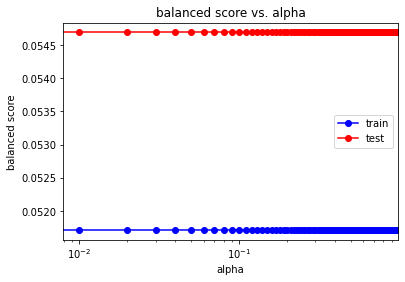

In [56]:
plot_scores(get_train_test_error, X_train, Y_train, np.arange(0,1,0.01), 'alpha', plot_legend = plot_legend_alpha_err)

Получились горизонатальные прямые, т.к. классификатор определяет все элементы к одному классу.

Посмотрим на график зависимости `error` от `alpha` для классификатора, обученного на выборке, к которой применен ресэмплинг.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.17it/s]
<ipython-input-54-795460f007ab>:43: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(plot_param), np.max(plot_param)])


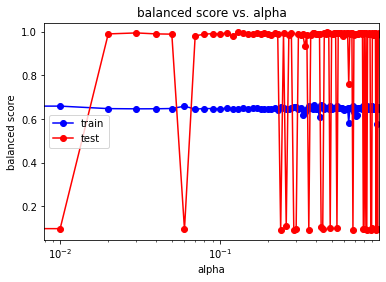

In [57]:
plot_scores(get_train_test_error, X_train_resample, Y_train_resample, np.arange(0,1,0.01), 
            'alpha', plot_legend = plot_legend_alpha_err)

Посмотрим на график зависимости `error` от кол-ва нейронов для классификатора.

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:37<00:00,  5.30it/s]


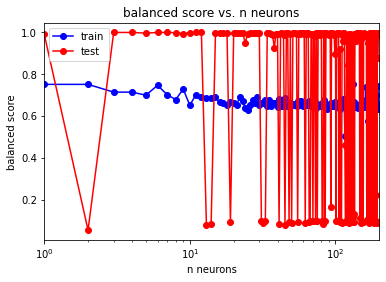

In [58]:
plot_scores(get_train_test_error, X_train, Y_train, layer_sizes, 'hidden_layer_sizes', plot_legend = plot_legend_neurons_err)

Посмотрим на график зависимости `balanced score` от кол-ва нейронов для классификатора, обученного на выборке, к которой применен ресэмплинг.

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:37<00:00,  5.26it/s]


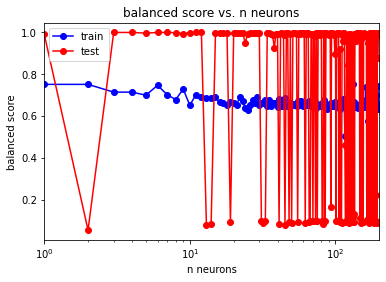

In [59]:
plot_scores(get_train_test_error, X_train_resample, Y_train_resample, layer_sizes,
            'hidden_layer_sizes', plot_legend = plot_legend_neurons_bal)

Посмотрим на график зависимости `balanced score` от `alpha`

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.50it/s]
<ipython-input-54-795460f007ab>:43: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(plot_param), np.max(plot_param)])


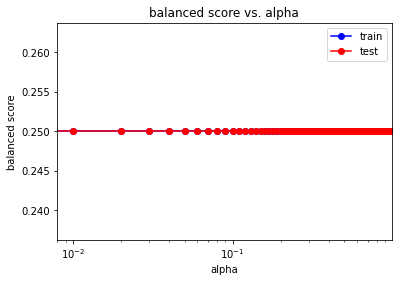

In [60]:
plot_scores(get_train_test_bal_score, X_train, Y_train, np.arange(0,1,0.01), 'alpha', plot_legend = plot_legend_alpha_bal)

Посмотрим на график зависимости `balanced score` от `alpha` для классификатора, обученного на выборке, к которой применен ресэмплинг.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.31it/s]
<ipython-input-54-795460f007ab>:43: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([np.min(plot_param), np.max(plot_param)])


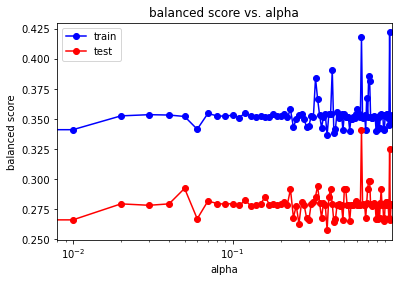

In [61]:
plot_scores(get_train_test_bal_score, X_train_resample, Y_train_resample, np.arange(0,1,0.01), 
            'alpha', plot_legend = plot_legend_alpha_bal)

Посмотрим на график зависимости `balanced score` от кол-ва нейронов для классификатора.

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:38<00:00,  5.20it/s]


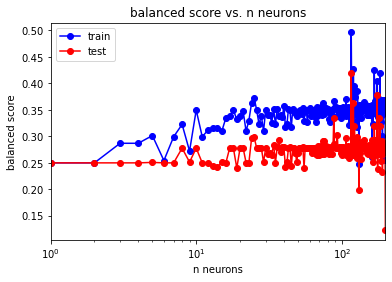

In [62]:


plot_scores(get_train_test_bal_score, X_train_resample, Y_train_resample, layer_sizes, 'hidden_layer_sizes', plot_legend = plot_legend_neurons_bal)

Посмотрим на график зависимости `balanced score` от кол-ва нейронов для классификатора, обученного на выборке, к которой применен ресэмплинг.

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:40<00:00,  4.94it/s]


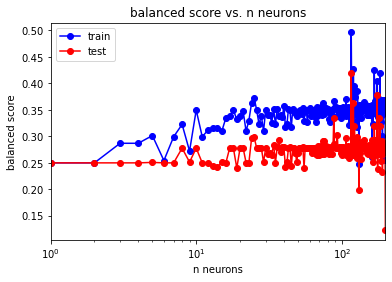

In [63]:
plot_scores(get_train_test_bal_score, X_train_resample, Y_train_resample, layer_sizes,
            'hidden_layer_sizes', plot_legend = plot_legend_neurons_bal)

Исходя из графиков для кол-ва нейронов и balanced score, видно, что оптимальное кол-во нейронов находится в районе 100.

Попробуем обучить двухслойную нейронную сеть.

In [74]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,100),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          max_iter=2000,
                            alpha= 0.1,
                          random_state = 1)
mlp_model.fit(X_train_resample, Y_train_resample)

C:\Users\Step2Victory\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=(100, 100),
              max_iter=2000, random_state=1, solver='lbfgs')

In [75]:
balanced_accuracy_score(Y_train_resample, mlp_model.predict(X_train_resample))

0.8707336210278541

In [76]:
balanced_accuracy_score(Y_test, mlp_model.predict(X_test))

0.8484434226061021

In [77]:
confusion_matrix(Y_test, mlp_model.predict(X_test))

array([[601,  72, 172,   2],
       [  0,   9,   0,   0],
       [  9,   2,  26,   1],
       [  0,   0,   0,   2]], dtype=int64)

Как видно, двухслойная нейронная сеть решает задачу значительно лучше. Balanced accuracy score составляет `0.85`